<a href="https://colab.research.google.com/github/Ayon1113/SteamEngine/blob/main/SteamEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub[pandas-datasets] --quiet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import re
from kagglehub import KaggleDatasetAdapter
from google.colab import files
import os
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack


In [ ]:
files.upload()

{}

In [ ]:

os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:

file_path='93182_steam_games.csv'
dataset_name = "joebeachcapital/top-1000-steam-games"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    dataset_name,
    file_path,
)

print("First 5 records:\n", df.head())


/tmp/ipython-input-1322783706.py:4: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 90.2M/90.2M [00:00<00:00, 138MB/s]

Extracting zip of 93182_steam_games.csv...


First 5 records:
      AppID                   Name  Release date Estimated owners  Peak CCU  \
0  1424640                     余烬   Oct 3, 2020    20000 - 50000         0   
1   402890            Nyctophilia  Sep 23, 2015   50000 - 100000         0   
2  1151740        Prison Princess   Apr 2, 2020        0 - 20000         0   
3   875530           Dead In Time  Oct 12, 2018        0 - 20000         0   
4  1835360  Panacle: Back To Wild  Mar 11, 2022        0 - 20000         2   

   Required age  Price  DLC count  \
0             0   3.99          0   
1             0   0.00          0   
2             0  19.99          0   
3             0   7.99          0   
4             0   3.99          0   

                                      About the game  \
0  'Ashes of war' is an anti war theme adventure ...   
1  NYCTOPHILIA Nyctophilia is an 2D psychological...   
2  ABOUT Now nothing more than a phantom, can the...   
3  Is a hardcore action with a non-trivial level ...   
4  Panacle

/usr/local/lib/python3.12/dist-packages/kagglehub/pandas_datasets.py:91: DtypeWarning: Columns (3,36) have mixed types. Specify dtype option on import or set low_memory=False.
  result = read_function(


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93182 entries, 0 to 93181
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AppID                       93182 non-null  int64  
 1   Name                        93179 non-null  object 
 2   Release date                93182 non-null  object 
 3   Estimated owners            16462 non-null  object 
 4   Peak CCU                    93182 non-null  int64  
 5   Required age                93182 non-null  int64  
 6   Price                       93182 non-null  float64
 7   DLC count                   93182 non-null  int64  
 8   About the game              88392 non-null  object 
 9   Supported languages         93182 non-null  object 
 10  Full audio languages        93182 non-null  object 
 11  Reviews                     10599 non-null  object 
 12  Header image                93182 non-null  object 
 13  Website                     416

Let's convert the release date into a proper date format

In [ ]:
df['Release date'] = pd.to_datetime(df['Release date'], format='%b %d, %Y', errors='coerce')

In [ ]:
df['Release date']

,Release date
0,2020-10-03
1,2015-09-23
2,2020-04-02
3,2018-10-12
4,2022-03-11
...,...
93177,2023-01-05
93178,2020-10-15
93179,2023-09-05
93180,2024-01-27


The age of a game may be associated with other values, doesn't hurt to check

In [ ]:
df['age_years'] = (datetime.now().year - df['Release date'].dt.year)

In [ ]:
df['age_years']

,age_years
0,5.0
1,10.0
2,5.0
3,7.0
4,3.0
...,...
93177,2.0
93178,5.0
93179,2.0
93180,1.0


In [ ]:
df = df[['AppID','Price','Name','Supported languages','About the game','Developers','Categories','Genres','age_years']]

In [ ]:
df.head()

,AppID,Name,Supported languages,About the game,Developers,Categories,Genres,age_years
0,1424640,余烬,['Simplified Chinese'],'Ashes of war' is an anti war theme adventure ...,宁夏华夏西部影视城有限公司,"Single-player,Family Sharing","Adventure,Casual,Indie,RPG",5.0
1,402890,Nyctophilia,"['English', 'Russian']",NYCTOPHILIA Nyctophilia is an 2D psychological...,Cat In A Jar Games,Single-player,"Adventure,Free To Play,Indie",10.0
2,1151740,Prison Princess,"['English', 'Simplified Chinese', 'Traditional...","ABOUT Now nothing more than a phantom, can the...",qureate,"Single-player,Steam Achievements,Full controll...","Adventure,Indie",5.0
3,875530,Dead In Time,"['English', 'Russian']",Is a hardcore action with a non-trivial level ...,Zelenov Artem,"Single-player,Full controller support,Family S...","Action,Indie",7.0
4,1835360,Panacle: Back To Wild,"['English', 'Japanese', 'Simplified Chinese', ...",Panacle: Back to the Wild is a indie card game...,渡鸦游戏,"Single-player,Family Sharing","Indie,Strategy,Early Access",3.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93182 entries, 0 to 93181
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AppID                93182 non-null  int64  
 1   Name                 93179 non-null  object 
 2   Supported languages  93182 non-null  object 
 3   About the game       88392 non-null  object 
 4   Developers           88349 non-null  object 
 5   Categories           87887 non-null  object 
 6   Genres               88381 non-null  object 
 7   age_years            93064 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 5.7+ MB


In [ ]:
df.isnull().sum()

,0
AppID,0
Name,3
Supported languages,0
About the game,4790
Developers,4833
Categories,5295
Genres,4801
age_years,118


We could drop the rows with null values, but that might be introducing some bias if there is a pattern with the missing data, let's observe further

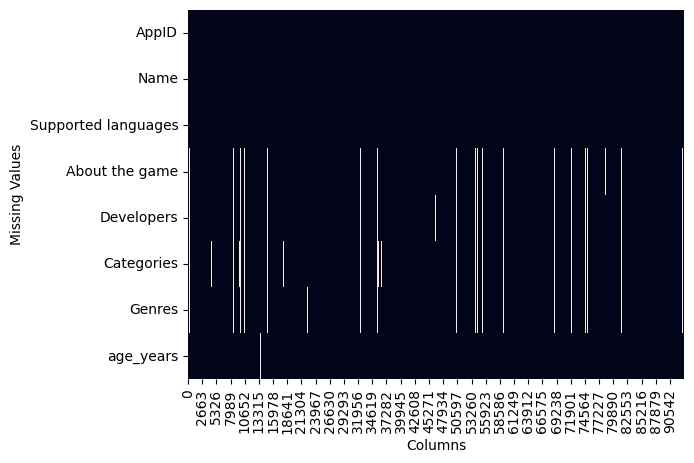

In [ ]:
ax = plt.axes()
sns.heatmap(df.isna().transpose(), ax=ax, cbar=False)
plt.xlabel("Columns")
plt.ylabel("Missing Values")
plt.show()

It seems that if a row has one of the features in [About the game, Developers, Categories, Genres] then it tends to have all of them missing.

Lets see what these rows look like

In [ ]:
df_missing = df[(df['About the game'].isna()) |
  (df['Developers'].isna()) |
  (df['Categories'].isna()) |
  (df['Genres'].isna())
]

In [ ]:
df_missing.head()

,AppID,Name,Supported languages,About the game,Developers,Categories,Genres,age_years
59,2998250,Isle Goblin Playtest,[],NaN,NaN,NaN,NaN,1.0
95,2871600,CodeReactors Playtest,[],NaN,NaN,NaN,NaN,1.0
158,1528760,Treasure Drifter: Nian Playtest,[],NaN,NaN,NaN,NaN,4.0
161,1980470,Fantasy Background Generator,['English'],Fantasy Background Generator (FBG) is a proced...,"Scopegoat Interactive,Andreas Hötzinger,Lukas ...",NaN,"Design & Illustration,Photo Editing,Utilities,...",3.0
165,2325980,I.H.A.S Playtest,[],NaN,NaN,NaN,NaN,1.0


We see a certain pattern here

In [ ]:
mask = df_missing['Name'].str.contains('Playtest', case=False, na=False)
percentage = mask.mean() * 100

print(f"{percentage:.2f}% of games contain 'Playtest' in the name.")


77.98% of games contain 'Playtest' in the name.


I think we have identified the pattern, that being the brunt of missing values are associated with the playtest version of a game, which isn't useful for us so we can go ahead and drop those rows.

In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

,0
AppID,0
Name,0
Supported languages,0
About the game,0
Developers,0
Categories,0
Genres,0
age_years,0


In [ ]:
df.head()

,AppID,Name,Supported languages,About the game,Developers,Categories,Genres,age_years
0,1424640,余烬,['Simplified Chinese'],'Ashes of war' is an anti war theme adventure ...,宁夏华夏西部影视城有限公司,"Single-player,Family Sharing","Adventure,Casual,Indie,RPG",5.0
1,402890,Nyctophilia,"['English', 'Russian']",NYCTOPHILIA Nyctophilia is an 2D psychological...,Cat In A Jar Games,Single-player,"Adventure,Free To Play,Indie",10.0
2,1151740,Prison Princess,"['English', 'Simplified Chinese', 'Traditional...","ABOUT Now nothing more than a phantom, can the...",qureate,"Single-player,Steam Achievements,Full controll...","Adventure,Indie",5.0
3,875530,Dead In Time,"['English', 'Russian']",Is a hardcore action with a non-trivial level ...,Zelenov Artem,"Single-player,Full controller support,Family S...","Action,Indie",7.0
4,1835360,Panacle: Back To Wild,"['English', 'Japanese', 'Simplified Chinese', ...",Panacle: Back to the Wild is a indie card game...,渡鸦游戏,"Single-player,Family Sharing","Indie,Strategy,Early Access",3.0


For our purposes we want to only deal with games that have English as a supported language.

In [ ]:
mask_english = df['Supported languages'].str.contains('English', case=False, na=False)

In [ ]:
df = df[mask_english]

In [ ]:
df

,AppID,Name,Supported languages,About the game,Developers,Categories,Genres,age_years
1,402890,Nyctophilia,"['English', 'Russian']",NYCTOPHILIA Nyctophilia is an 2D psychological...,Cat In A Jar Games,Single-player,"Adventure,Free To Play,Indie",10.0
2,1151740,Prison Princess,"['English', 'Simplified Chinese', 'Traditional...","ABOUT Now nothing more than a phantom, can the...",qureate,"Single-player,Steam Achievements,Full controll...","Adventure,Indie",5.0
3,875530,Dead In Time,"['English', 'Russian']",Is a hardcore action with a non-trivial level ...,Zelenov Artem,"Single-player,Full controller support,Family S...","Action,Indie",7.0
4,1835360,Panacle: Back To Wild,"['English', 'Japanese', 'Simplified Chinese', ...",Panacle: Back to the Wild is a indie card game...,渡鸦游戏,"Single-player,Family Sharing","Indie,Strategy,Early Access",3.0
5,431510,Mystic Destinies: Serendipity of Aeons,['English'],MDSOA is now 100% complete! You can purchase t...,Aeon Dream Studios,"Single-player,Steam Achievements,Steam Trading...","Adventure,Casual,Indie,Simulation",9.0
...,...,...,...,...,...,...,...,...
93177,2251030,Mutant Monty (C64/CPC/Spectrum),['English'],Originally released in 1984 for home microcomp...,Artic Computing,"Single-player,Partial Controller Support,Steam...",Action,2.0
93178,1330890,Crystal Caves HD,['English'],The best miner in the Galaxy is back! Revisit ...,Emberheart Games,"Single-player,Steam Achievements,Full controll...",Action,5.0
93179,1844230,Malicious ReloadⅡ,"['Japanese', 'English', 'Simplified Chinese', ...",★ To ensure that the game you have purchased w...,UNDER HILL,"Single-player,Family Sharing","Action,Adventure,Simulation",2.0
93180,2623690,Mutant Frog,['English'],As a result of an unknown meteorite hitting an...,Run-O Games,"Single-player,Family Sharing","Action,Adventure,Casual,Indie",1.0


For double safety we can remove all descriptions in the "about the game" feature where the language is not english.

In [ ]:
#CHATGPT
def is_english_fast(text):
    text = str(text)
    if not text:
        return False

    # 1️⃣ Check proportion of ASCII characters
    non_ascii = sum(1 for c in text if ord(c) > 127)
    if non_ascii / len(text) > 0.1:  # >10% non-ASCII = likely non-English
        return False

    # 2️⃣ Look for common English words
    common_words = ["the", "and", "is", "to", "of", "in", "you", "for", "game"]
    hits = sum(w in text.lower() for w in common_words)
    return hits >= 2

In [ ]:
df = df[df["About the game"].apply(is_english_fast)]

In [ ]:
df

,AppID,Name,Supported languages,About the game,Developers,Categories,Genres,age_years
1,402890,Nyctophilia,"['English', 'Russian']",NYCTOPHILIA Nyctophilia is an 2D psychological...,Cat In A Jar Games,Single-player,"Adventure,Free To Play,Indie",10.0
2,1151740,Prison Princess,"['English', 'Simplified Chinese', 'Traditional...","ABOUT Now nothing more than a phantom, can the...",qureate,"Single-player,Steam Achievements,Full controll...","Adventure,Indie",5.0
3,875530,Dead In Time,"['English', 'Russian']",Is a hardcore action with a non-trivial level ...,Zelenov Artem,"Single-player,Full controller support,Family S...","Action,Indie",7.0
4,1835360,Panacle: Back To Wild,"['English', 'Japanese', 'Simplified Chinese', ...",Panacle: Back to the Wild is a indie card game...,渡鸦游戏,"Single-player,Family Sharing","Indie,Strategy,Early Access",3.0
5,431510,Mystic Destinies: Serendipity of Aeons,['English'],MDSOA is now 100% complete! You can purchase t...,Aeon Dream Studios,"Single-player,Steam Achievements,Steam Trading...","Adventure,Casual,Indie,Simulation",9.0
...,...,...,...,...,...,...,...,...
93177,2251030,Mutant Monty (C64/CPC/Spectrum),['English'],Originally released in 1984 for home microcomp...,Artic Computing,"Single-player,Partial Controller Support,Steam...",Action,2.0
93178,1330890,Crystal Caves HD,['English'],The best miner in the Galaxy is back! Revisit ...,Emberheart Games,"Single-player,Steam Achievements,Full controll...",Action,5.0
93179,1844230,Malicious ReloadⅡ,"['Japanese', 'English', 'Simplified Chinese', ...",★ To ensure that the game you have purchased w...,UNDER HILL,"Single-player,Family Sharing","Action,Adventure,Simulation",2.0
93180,2623690,Mutant Frog,['English'],As a result of an unknown meteorite hitting an...,Run-O Games,"Single-player,Family Sharing","Action,Adventure,Casual,Indie",1.0


In [ ]:
df.drop('Supported languages',axis='columns',inplace=True)

/tmp/ipython-input-2780319087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('Supported languages',axis='columns',inplace=True)


Now that our data frame only consists of games with English support, we don't need the Supported languages column anymore

Ok now, we need to convert the categories and genres columns into something usable for the model because as it stands right now the info can't properly be utilized

In [ ]:
df['Categories'].unique()

array(['Single-player',
       'Single-player,Steam Achievements,Full controller support,Family Sharing',
       'Single-player,Full controller support,Family Sharing', ...,
       'Single-player,Multi-player,PvP,Shared/Split Screen PvP,Co-op,Shared/Split Screen Co-op,Shared/Split Screen,Steam Achievements,Full controller support,Tracked Controller Support,VR Supported,Steam Trading Cards,VR Support,Remote Play Together,Family Sharing',
       'Single-player,Multi-player,PvP,Shared/Split Screen PvP,Shared/Split Screen,Steam Achievements,Stats,Remote Play Together',
       'Single-player,Multi-player,PvP,Online PvP,Co-op,Online Co-op,Steam Achievements,Steam Workshop,Steam Cloud,Stats,Includes level editor,Family Sharing'],
      dtype=object)

In [ ]:
df[df["Categories"].str.contains("PvP")]

,AppID,Name,About the game,Developers,Categories,Genres,age_years
8,1154840,Shadow Empire,Shadow Empire is a deep turn-based 4X wargame ...,VR Designs,"Single-player,Multi-player,PvP,Shared/Split Sc...","RPG,Simulation,Strategy",5.0
10,1292170,Krush Kill 'N Destroy Xtreme,"Ahh, the post-nuclear army life where you meet...","Beam Software Pty., Ltd.","Single-player,Multi-player,PvP,LAN PvP,Family ...",Strategy,5.0
40,1343700,Break Space: Out of Bounds,A CLASSIC ARCADE WITH A DIFFERENT THEME Break ...,Magic Fountain Studio,"Single-player,Multi-player,PvP,Shared/Split Sc...","Action,Casual,Indie,Strategy",5.0
48,252850,Streamline,"Welcome to Streamline, a fast-paced, third per...",Proletariat Inc.,"Multi-player,Online PvP,Steam Achievements,Ste...","Action,Indie,Sports,Early Access",9.0
49,626550,Prodigy Tactics,"In the world of Thasys, most races rely on Man...",Hanakai Studio,"Single-player,Multi-player,PvP,Online PvP,Fami...","Action,Adventure,Casual,RPG,Strategy",7.0
...,...,...,...,...,...,...,...
93132,689620,Alpha Mike Foxtrot VR - AMF VR,Get ready for the Next Generation in Virtual R...,SUBLEVEL ONE STUDIOS,"Single-player,Multi-player,PvP,Online PvP,Co-o...","Violent,Action,Indie,Simulation",7.0
93141,1003940,Invasion Zero,Invasion Zero is a multi-player online free to...,Plancksoft,"Multi-player,PvP,Online PvP,Cross-Platform Mul...","Action,Free To Play,Indie,Massively Multiplayer",6.0
93148,790450,ANYKEY,Warning: This game features flashing visuals w...,Yali Izzo,"Single-player,Multi-player,PvP,Shared/Split Sc...","Action,Casual,Free To Play,Indie",7.0
93159,345460,War of Omens Card Game,CHOOSE YOUR FACTION Play as the rich and ancie...,Fifth Column Games,"Single-player,Multi-player,PvP,Online PvP,Cros...","Free To Play,Indie,Strategy",6.0


Ok, this is where a little bit of ***domain knowledge*** becomes useful. There are 6 different groupings of categories we have and then in those groups we have even more different values, but only a handful of all these values are categories that most people would realistically search for.

I believe 4 are the stand out which are Single-player,Multi-player,PvP, and Co-op

In [ ]:
df['Singleplayer'] = df['Categories'].str.contains('Single-player', case=False, na=False)
df['Multiplayer'] = df['Categories'].str.contains('Multi-player', case=False, na=False)
df['PvP'] = df['Categories'].str.contains('PvP', case=False, na=False)
df['CO_OP'] = df['Categories'].str.contains('Co-op', case=False, na=False)

/tmp/ipython-input-4226763349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Singleplayer'] = df['Categories'].str.contains('Single-player', case=False, na=False)
/tmp/ipython-input-4226763349.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Multiplayer'] = df['Categories'].str.contains('Multi-player', case=False, na=False)
/tmp/ipython-input-4226763349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [ ]:
df['Singleplayer'] = df['Singleplayer'].astype(int)
df['Multiplayer'] = df['Multiplayer'].astype(int)
df['PvP'] = df['PvP'].astype(int)
df['CO_OP'] = df['CO_OP'].astype(int)

/tmp/ipython-input-1651310555.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Singleplayer'] = df['Singleplayer'].astype(int)
/tmp/ipython-input-1651310555.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Multiplayer'] = df['Multiplayer'].astype(int)
/tmp/ipython-input-1651310555.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [ ]:
df

,AppID,Name,About the game,Developers,Categories,Genres,age_years,Singleplayer,Multiplayer,PvP,CO_OP
1,402890,Nyctophilia,NYCTOPHILIA Nyctophilia is an 2D psychological...,Cat In A Jar Games,Single-player,"Adventure,Free To Play,Indie",10.0,1,0,0,0
2,1151740,Prison Princess,"ABOUT Now nothing more than a phantom, can the...",qureate,"Single-player,Steam Achievements,Full controll...","Adventure,Indie",5.0,1,0,0,0
3,875530,Dead In Time,Is a hardcore action with a non-trivial level ...,Zelenov Artem,"Single-player,Full controller support,Family S...","Action,Indie",7.0,1,0,0,0
4,1835360,Panacle: Back To Wild,Panacle: Back to the Wild is a indie card game...,渡鸦游戏,"Single-player,Family Sharing","Indie,Strategy,Early Access",3.0,1,0,0,0
5,431510,Mystic Destinies: Serendipity of Aeons,MDSOA is now 100% complete! You can purchase t...,Aeon Dream Studios,"Single-player,Steam Achievements,Steam Trading...","Adventure,Casual,Indie,Simulation",9.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
93177,2251030,Mutant Monty (C64/CPC/Spectrum),Originally released in 1984 for home microcomp...,Artic Computing,"Single-player,Partial Controller Support,Steam...",Action,2.0,1,0,0,0
93178,1330890,Crystal Caves HD,The best miner in the Galaxy is back! Revisit ...,Emberheart Games,"Single-player,Steam Achievements,Full controll...",Action,5.0,1,0,0,0
93179,1844230,Malicious ReloadⅡ,★ To ensure that the game you have purchased w...,UNDER HILL,"Single-player,Family Sharing","Action,Adventure,Simulation",2.0,1,0,0,0
93180,2623690,Mutant Frog,As a result of an unknown meteorite hitting an...,Run-O Games,"Single-player,Family Sharing","Action,Adventure,Casual,Indie",1.0,1,0,0,0


Now we have no need for the categories column

In [ ]:
df.drop('Categories',axis='columns',inplace=True)

/tmp/ipython-input-3498516125.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('Categories',axis='columns',inplace=True)


In [ ]:
df

,AppID,Name,About the game,Developers,Genres,age_years,Singleplayer,Multiplayer,PvP,CO_OP
1,402890,Nyctophilia,NYCTOPHILIA Nyctophilia is an 2D psychological...,Cat In A Jar Games,"Adventure,Free To Play,Indie",10.0,1,0,0,0
2,1151740,Prison Princess,"ABOUT Now nothing more than a phantom, can the...",qureate,"Adventure,Indie",5.0,1,0,0,0
3,875530,Dead In Time,Is a hardcore action with a non-trivial level ...,Zelenov Artem,"Action,Indie",7.0,1,0,0,0
4,1835360,Panacle: Back To Wild,Panacle: Back to the Wild is a indie card game...,渡鸦游戏,"Indie,Strategy,Early Access",3.0,1,0,0,0
5,431510,Mystic Destinies: Serendipity of Aeons,MDSOA is now 100% complete! You can purchase t...,Aeon Dream Studios,"Adventure,Casual,Indie,Simulation",9.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
93177,2251030,Mutant Monty (C64/CPC/Spectrum),Originally released in 1984 for home microcomp...,Artic Computing,Action,2.0,1,0,0,0
93178,1330890,Crystal Caves HD,The best miner in the Galaxy is back! Revisit ...,Emberheart Games,Action,5.0,1,0,0,0
93179,1844230,Malicious ReloadⅡ,★ To ensure that the game you have purchased w...,UNDER HILL,"Action,Adventure,Simulation",2.0,1,0,0,0
93180,2623690,Mutant Frog,As a result of an unknown meteorite hitting an...,Run-O Games,"Action,Adventure,Casual,Indie",1.0,1,0,0,0


In [ ]:
df = df.reset_index(drop=True)

In [ ]:
tfidf_about = TfidfVectorizer(stop_words='english', max_features=10000)
tfidf_genre = TfidfVectorizer(token_pattern=r'[^,]+')

X_about = tfidf_about.fit_transform(df['About the game'].fillna(''))
X_genre = tfidf_genre.fit_transform(df['Genres'].fillna(''))

# Apply weights
about_weight = 4.0
genre_weight = 1.0

X_combined = hstack([
    X_about * about_weight,
    X_genre * genre_weight,
    df[['Singleplayer', 'Multiplayer', 'PvP', 'CO_OP']].fillna(0).values
])

In [ ]:
feature_matrix = X_combined

In [ ]:
#CHATGPT
def recommend(game_title, n=5):
    idx = df[df['Name'].str.lower() == game_title.lower()].index[0]
    target_vec = feature_matrix.getrow(idx)
    sim_scores = cosine_similarity(target_vec, feature_matrix).flatten()
    similar_idx = sim_scores.argsort()[-n-1:-1][::-1]
    return df.iloc[similar_idx][['Name', "About the game", 'Genres']]

In [ ]:
recommend('Street Fighter V')

,Name,About the game,Genres
8782,Street Fighter X Tekken,Will You Cross the Line? The long awaited drea...,Action
8127,Street Fighter® IV,Street Fighter® IV brings the legendary fighti...,Action
38399,Street Fighter 30th Anniversary Collection,Celebrate Street Fighter’s historic legacy wit...,Action
52328,Ultra Street Fighter® IV,The world’s greatest fighting game evolves to ...,Action
78215,Street Fighter™ 6,Here comes Capcom’s newest challenger! Street ...,"Action,Adventure"


np.int64(24317)

In [ ]:
df.to_csv("cleaned_steam_games.csv", index=False)


NameError: name 'df' is not defined